# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [55]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/1ib/python3.10/site-packages"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [1]:
# Install requirements
!pip show numpy

Name: numpy
Version: 1.26.4
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2023, NumPy Developers.
        All rights reserved.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are
        met:
        
            * Redistributions of source code must retain the above copyright
               notice, this list of conditions and the following disclaimer.
        
            * Redistributions in binary form must reproduce the above
               copyright notice, this list of conditions and the following
               disclaimer in the documentation and/or other materials provided
               with the distribution.
        
            * Neither the name of the NumPy Developers nor the names of any
               contributors may be used to endorse or promo

In [2]:
# Install requirements
!python -m pip install -r requirements.txt

  Using cached opencv-python-headless-4.5.3.56.tar.gz (89.2 MB)
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [842 lines of output]
      Ignoring numpy: markers 'python_version == "3.6" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version >= "3.6" and sys_platform == "linux" and platform_machine == "aarch64"' don't match your environment
      Ignoring numpy: markers 'python_version >= "3.6" and sys_platform == "darwin" and platform_machine == "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.8" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your

## Imports

In [40]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import random

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [42]:
# Defining transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading the dataset
mnist_dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)

# Defining the sizes of train, validation, and test sets
train_size = int(0.6 * len(mnist_dataset))  # 60% for training
val_size = int(0.2 * len(mnist_dataset))    # 20% for validation
test_size = len(mnist_dataset) - train_size - val_size  # Remaining for test (20%)

# Splitting the MNIST dataset 

train_dataset, val_dataset, test_dataset = random_split(mnist_dataset, [train_size, val_size, test_size])

# Create test set and define test dataloader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?


**The only preprocessing made was "Normlization" to convert the grayscale values to tensors with numbers between 0 and 1. The image size in this dataset seems perfect - 28*28 - and we will not need to rotate images or flip them since we will predict images which are always in the right rotations (for example, number four flipped is not actually four)**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [22]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

8


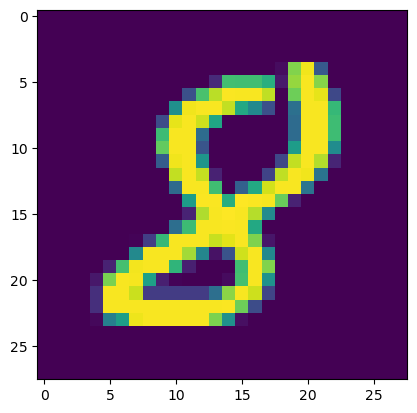

7


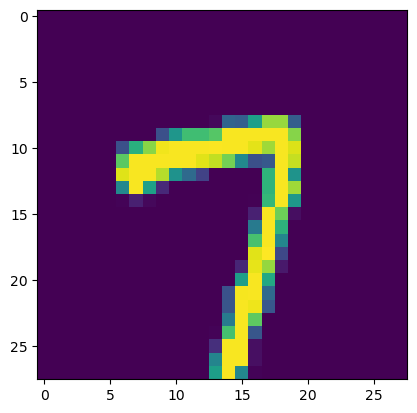

7


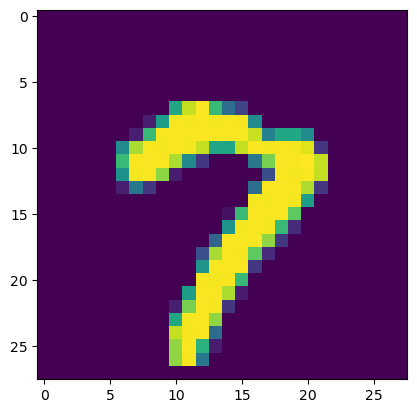

2


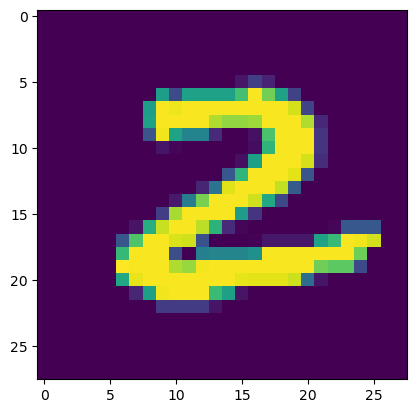

3


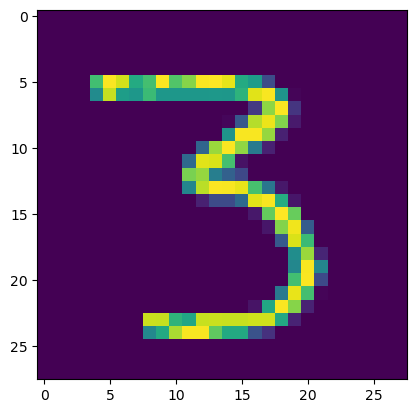

In [23]:
# Explore data
show5(train_loader)

In [24]:
# Explore data
print("Number of MNIST train data examples: {}".format(len(train_data)))
print("Number of MNIST test data examples: {}".format(len(test_data)))

Number of MNIST train data examples: 60000
Number of MNIST test data examples: 10000


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [28]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28 * 28 * 1, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        x = F.softmax(x, dim=1)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [29]:
net = Net()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.99, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [30]:
# Move the model to the GPU if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)

Plot the training loss (and validation loss/accuracy, if recorded).

In [31]:
# number of epochs
num_epochs = 20

# creating lists for loss history
train_loss_history = list()
val_loss_history = list()

# The start of the training
for epoch in range(num_epochs):
    # putting the model in training mode
    net.train()
    # setting the epoch loss and number of correct predictions to zero
    train_loss = 0.0
    train_correct = 0
    total_predictions = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()
    
        outputs = net(inputs)
    
        loss = criterion(outputs, labels)
    
        loss.backward()
    
        optimizer.step()
    
        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        
    print(f"Epoch {epoch + 1} training accuracy: {train_correct/total_predictions * 100:.2f}% training loss: {train_loss/len(train_loader):.5f}")
    train_loss_history.append(train_loss/len(train_loader))
    
    # The validation phase
    val_loss = 0.0
    val_correct = 0
    total_predictions = 0
    net.eval()
    for inputs, labels in val_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f"Epoch {epoch + 1} validation accuracy: {val_correct/total_predictions * 100:.2f}% validation loss: {val_loss/len(val_loader):.5f}")
    val_loss_history.append(val_loss/len(val_loader))

Epoch 1 training accuracy: 33.54% training loss: 2.13783
Epoch 1 validation accuracy: 58.20% validation loss: 1.87566
Epoch 2 training accuracy: 71.97% training loss: 1.73990
Epoch 2 validation accuracy: 76.23% validation loss: 1.69800
Epoch 3 training accuracy: 77.85% training loss: 1.68212
Epoch 3 validation accuracy: 80.64% validation loss: 1.65428
Epoch 4 training accuracy: 81.06% training loss: 1.65008
Epoch 4 validation accuracy: 82.33% validation loss: 1.63766
Epoch 5 training accuracy: 83.07% training loss: 1.63074
Epoch 5 validation accuracy: 84.30% validation loss: 1.61925
Epoch 6 training accuracy: 84.14% training loss: 1.62113
Epoch 6 validation accuracy: 86.50% validation loss: 1.60013
Epoch 7 training accuracy: 90.41% training loss: 1.56192
Epoch 7 validation accuracy: 91.67% validation loss: 1.54706
Epoch 8 training accuracy: 91.69% training loss: 1.54723
Epoch 8 validation accuracy: 90.28% validation loss: 1.56528
Epoch 9 training accuracy: 92.36% training loss: 1.54100

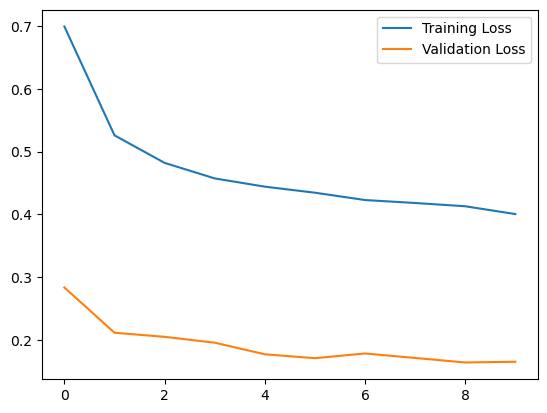

In [13]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [32]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100
    
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 94.19%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

**For improving the model, I decreased the learning rate from 0.01 to 0.001. The first training phase was for finding the right weights and taking huge steps to find them. The second one - the one in the coming code cells - is to take smaller steps to fine-tune the model and get a better accuracy**

In [33]:
# exprimenting with the optimizer

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.99, weight_decay= 0.001)

In [34]:
# number of epochs
num_epochs = 20

# creating lists for loss history
train_loss_history = list()
val_loss_history = list()

# The start of the training
for epoch in range(num_epochs):
    # putting the model in training mode
    net.train()
    # setting the epoch loss and number of correct predictions to zero
    train_loss = 0.0
    train_correct = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()
    
        outputs = net(inputs)
    
        loss = criterion(outputs, labels)
    
        loss.backward()
    
        optimizer.step()
    
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        
    print(f"Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader.dataset) * 100:.2f}% training loss: {train_loss/len(train_loader):.5f}")
    train_loss_history.append(train_loss/len(train_loader))
    
    # The validation phase
    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f"Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader.dataset) * 100:.2f}% validation loss: {val_loss/len(test_loader):.5f}")
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 95.95% training loss: 1.50540
Epoch 1 validation accuracy: 95.74% validation loss: 1.50808
Epoch 2 training accuracy: 96.52% training loss: 1.49916
Epoch 2 validation accuracy: 95.97% validation loss: 1.50556
Epoch 3 training accuracy: 96.70% training loss: 1.49771
Epoch 3 validation accuracy: 96.11% validation loss: 1.50535
Epoch 4 training accuracy: 96.83% training loss: 1.49699
Epoch 4 validation accuracy: 95.98% validation loss: 1.50544
Epoch 5 training accuracy: 96.94% training loss: 1.49693
Epoch 5 validation accuracy: 96.11% validation loss: 1.50540
Epoch 6 training accuracy: 97.05% training loss: 1.49577
Epoch 6 validation accuracy: 96.25% validation loss: 1.50516
Epoch 7 training accuracy: 97.14% training loss: 1.49561
Epoch 7 validation accuracy: 96.23% validation loss: 1.50450
Epoch 8 training accuracy: 97.19% training loss: 1.49491
Epoch 8 validation accuracy: 96.38% validation loss: 1.50376
Epoch 9 training accuracy: 97.32% training loss: 1.49449

## Final accuracy after tweaking the model

In [35]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100
    
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 96.61%


## Saving your model
Using `torch.save`, save your model for future loading.

In [39]:
torch.save(net.state_dict(), "saved_model.pth")